In [30]:
import subprocess

import networkx as nx
from networkx import MultiDiGraph

import matplotlib.pyplot as plt

In [53]:
# What: Find all files with a '.v' file extension and make into a list
def find_coq_files():
    #TODO: Bash should be in another file
    #What: Given the current directory of the python file, iterate through all sub directories
    #      and print out all files with a .v extension
    #Still clueless: https://explainshell.com/explain?cmd=find+.+-type+f+-name+%27*.v%27
    bash_command = "find . -type f -name '*.v'"
    #What: 
#         subprocess.check_output: do a command and give the output in bytes
#           ['bash', '-c', bash_commad]: more or less just put the pieces together execute
#         .decode('utf-8'): Take the current byte format (b'') and make it into a normal string
#         .split('\n'): Output is separated by newlines, so each newline should be a new file
#   Note: not sure why I need 'bash -c' here and not anywhere else?
    file_locations =subprocess.check_output(['bash', '-c', bash_command]).decode('utf-8').split('\n')
    return file_locations
file_locations = find_coq_files()

In [46]:
# What:Return a list of file names without the file extension
def names_of_files(file_locations):
    names_of = list()
    for i in file_locations:
        names_of.append(i               #The specific file location
                            .split("/") #Split the file path
                            [-1]        #Select the file name
                            [0:-2]      #Select the file name without the '.v' at the end
                        )
    return names_of
names_of = names_of_files(file_locations)

In [61]:
#What: Look through every file and return lines that have 'Require'
def find_import_state(file_locations):
    import_list = list()
    for i in file_locations:
        try:
            import_list.append(subprocess.check_output
                                (
                                    ["grep", "Require", i] #Search for the word Require at the filepath
                                )
                                .decode('utf-8')
                                .replace("Require Import ","") #Remove text so only the file is left
                                .split(".\n")
                                [:-1] #Select everything but the last '\n' that was split
            )
        except subprocess.CalledProcessError as e:
            import_list.append([])
    return import_list

import_list = find_import_state(file_locations)

In [64]:
#Make the file path look like a coq import statement
#Example : ./path/to/somewhere -> path.to.somewhere
def file_name_to_coq(file_locations):
    list_field = list()
    for i in file_locations:
        list_field.append((
            i[1:] #Remove the '.' at the beginning of the path
            .replace(".v","")
            .replace("/",".") # Make the path look like a coq import
        ))
    return list_field
list_field = file_name_to_coq(file_locations)

In [67]:
#What: Given a list of list's of strings, return a list of strings
def flatten_list(list_of):
    flat_return = []
    for sublist in list_of:
        for item in sublist:
            flat_return.append(item)
    return flat_return

#Combine all files and imports
def all_terms(list_field,import_list):
    s1 = set( #set keeps only unique elements
        list_field
    )
    flat_list = flatten_list(import_list)
    s2 = set(flat_list)
    total_terms = list( #List's make me happy
                    s1.
                        union #Elements in s1 or s2
                        (s2)
                      )
    return total_terms

In [23]:
#What: Strings -> Numbers for networkx
def replace_thing(big_list, small_list):
    return_list = list()
    #Similar structure to flatten()
    for sublist in small_list:
        #Check to make sure that the sublist isn't just an string
        if isinstance(sublist, list):
            struct_list = list()
            for item in sublist:
                 #Give the index of the element in the combined list
                struct_list.append(big_list.index(item))
            return_list.append(struct_list)
        #If it is a string then append away
        if isinstance(sublist, str):
            return_list.append(big_list.index(sublist))
    return return_list

In [24]:
# What: Didn't want to zip, so have dict[file name]=[list of imports] 
def string_to_num_dict(import_list, list_field):
    total_terms = all_terms(list_field, import_list)
    num_import_list = replace_thing(total_terms, import_list)
    num_field_list = replace_thing(total_terms, list_field)
    dummy_dict = dict()
    for ind, i in enumerate(num_field_list):
#       List is to preserve structure of import_list
        temp=list()
        for k in num_import_list[ind]:
            temp2 = total_terms[k]
#             Fucked up parsing at some point, overly complicated and needs revision
            if "."+total_terms[k] in list_field:
                temp.append(k)
#         Don't append empty lists, additional structure makes it hard to zip later
        if len(temp)>0:
            dummy_dict[i]=temp
    return dummy_dict
dummy_dict = string_to_num_dict(import_list, list_field)

In [25]:
# What: Given a dictionary with keys of integers and a list of integers return a multidigraph
#Notes: Why am I using a multidigraph and not just a digraph?
def dict_to_graph(dummy_dict):
    temp_graph = MultiDiGraph()
    for i in dummy_dict.keys():
        if isinstance(i,int):
            for j in dummy_dict[i]:
                if isinstance(j,list):
                    for k in j:
                        #Check if it is an integer(not a list), and that the edge isn't already added
                        if isinstance(k,int) and not((i,k) in temp_graph.edges()):
                            temp_graph.add_edge(i,k)
                else:
                    temp_graph.add_edge(i,j)
    return temp_graph
temp_graph = dict_to_graph(dummy_dict)

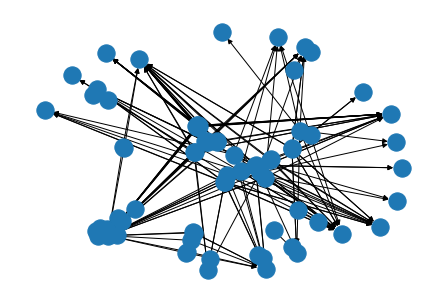

In [26]:
nx.draw_spring(temp_graph)
plt.show()

In [ ]:
# Notes:
#Question: If I wanted to make something to compile the .v files in a nice way how would I do it?
#Response: Maybe have it so the in degree is sorted first(low to high), and within the same out degree sort for the in degree(high to low).

In [12]:
# print(*zip(temp_graph.out_degree, temp_graph.in_degree))
# temp = zip(*temp_graph.out_degree)
# print(*zip(list(temp)[1],list(zip(*temp_graph.in_degree))[1]))